# Prediction of Stock Price Time Series using Transformers - Costa et al.

The data used was about brazilian stocks.

We will start with downloading from Yahoo Finance. Later on we can try B3 directly or private sources.

### Downloading Data

In [46]:
#pip install time-series-transformer

In [47]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import yfinance as yf
import pmdarima as pm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


In [48]:
tickers = ["BBDC4.SA", "BRAP4.SA", "CMIG4.SA", "GGBR4.SA",
           "GOAU4.SA", "GOLL4.SA", "ITSA4.SA", "ITUB4.SA"]

data = yf.download(tickers, start="2008-01-01", end="2008-04-30", auto_adjust=False)

average_prices = {}

for ticker in tickers:
    df = data.xs(ticker, level=1, axis=1).copy()
    df.loc[:, "average_price"] = (df["Open"] + df["Close"]) / 2
    average_prices[ticker] = df["average_price"]

average_prices_df = pd.DataFrame(average_prices)

[*********************100%***********************]  8 of 8 completed


The data is numerically different from the one seen in Table 1 in Costa and Machado, let's plot the trends to see if they compare.

In [49]:
average_prices_df.head()

,BBDC4.SA,BRAP4.SA,CMIG4.SA,GGBR4.SA,GOAU4.SA,GOLL4.SA,ITSA4.SA,ITUB4.SA
Date,,,,,,,,
2008-01-02,22.783214,21.943068,6.445429,20.619047,34.825001,43.195002,4.472711,13.414911
2008-01-03,21.845862,21.341477,6.392854,20.619047,34.682499,40.595001,4.346637,12.960320
2008-01-04,21.552811,20.827475,6.348061,20.619047,34.605000,39.684999,4.344697,12.979889
2008-01-07,21.573595,20.463294,6.292576,20.619047,33.652500,39.000000,4.315603,12.969352
2008-01-08,22.082798,20.186701,6.307187,20.619047,33.325001,38.865000,4.364093,13.139447


In [50]:
average_prices_df.tail()

,BBDC4.SA,BRAP4.SA,CMIG4.SA,GGBR4.SA,GOAU4.SA,GOLL4.SA,ITSA4.SA,ITUB4.SA
Date,,,,,,,,
2008-04-23,22.275048,22.132074,6.620685,20.619047,41.872499,24.280,4.263234,13.055152
2008-04-24,22.331165,21.597326,6.810539,20.619047,40.977501,24.510,4.220563,13.003973
2008-04-25,22.854917,21.159388,7.015004,20.619047,40.309999,25.070,4.280690,13.201164
2008-04-28,23.076264,21.493604,6.546681,20.619047,40.737499,25.280,4.344697,13.420931
2008-04-29,22.462103,21.228535,6.446403,20.619047,41.000000,25.725,4.309784,13.299006


Check for missing values.

In [51]:
# Check for missing values
missing_summary = average_prices_df.isnull().sum()

print("Missing values per stock:")
print(missing_summary)

# Show dates with any missing values
if missing_summary.sum() > 0:
    print("\nDates with missing values:")
    print(average_prices_df[average_prices_df.isnull().any(axis=1)])


Missing values per stock:
BBDC4.SA    0
BRAP4.SA    0
CMIG4.SA    0
GGBR4.SA    0
GOAU4.SA    0
GOLL4.SA    0
ITSA4.SA    0
ITUB4.SA    0
dtype: int64


Plotting. Trends are almost exactly identical to "Figure 3. Stock prices in each time period.", except GGBR4.SA.

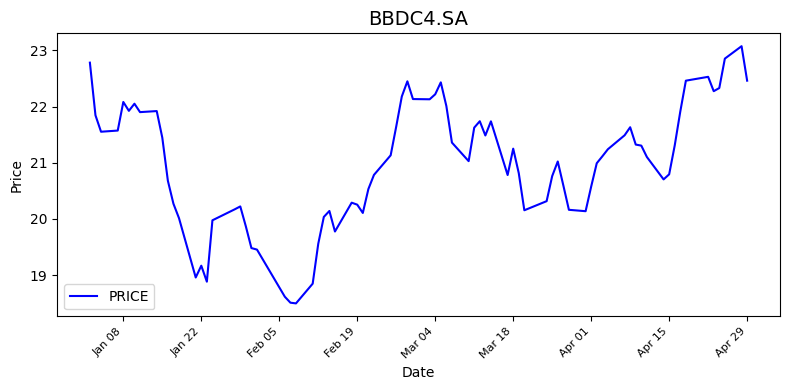

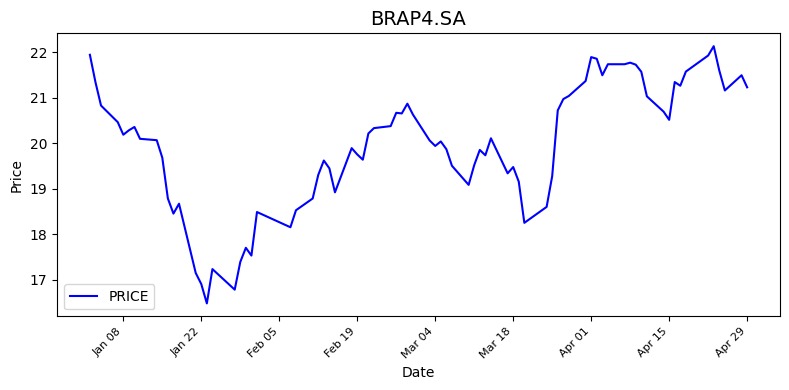

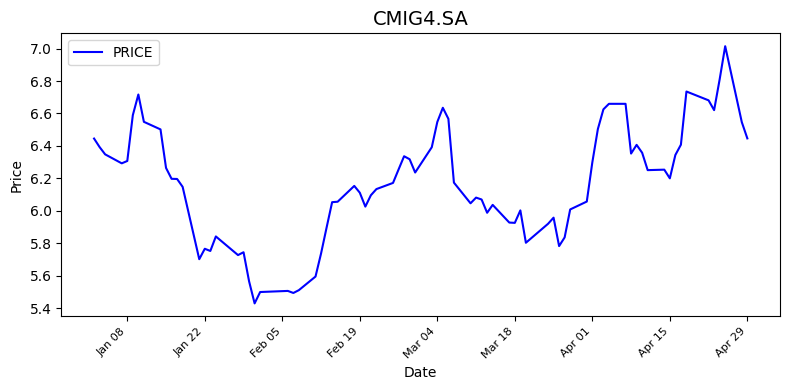

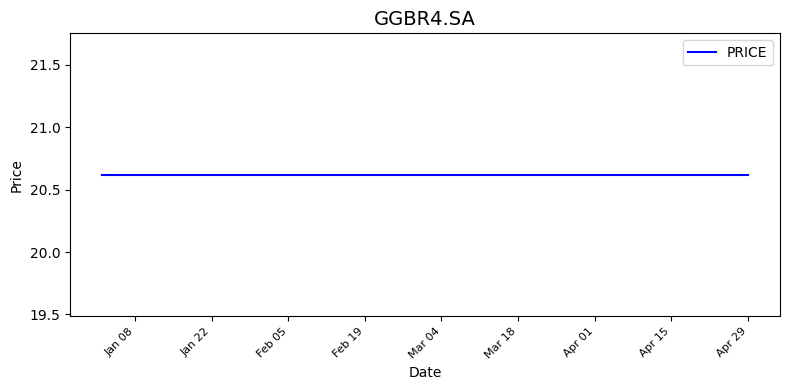

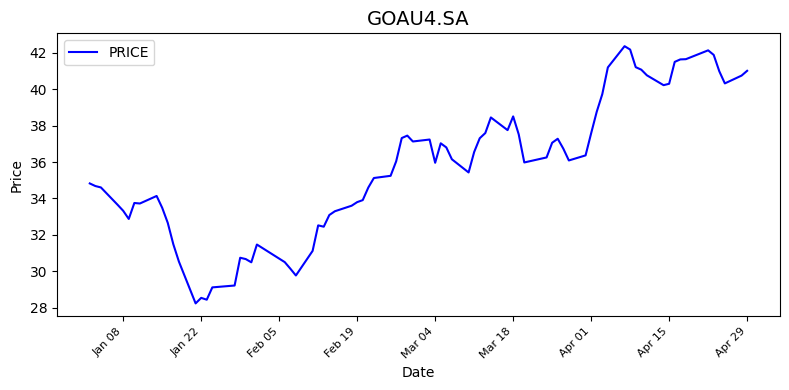

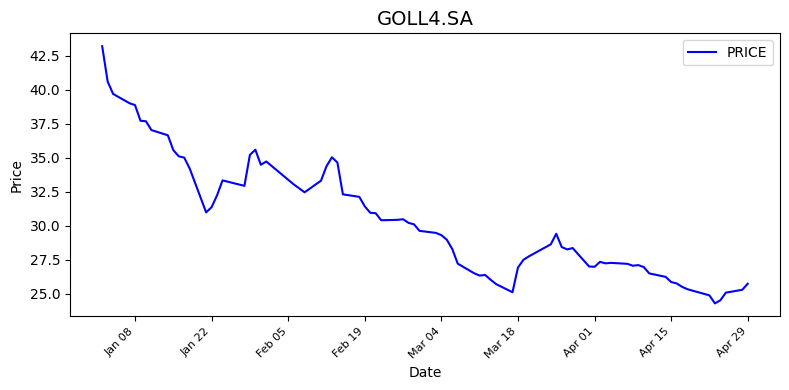

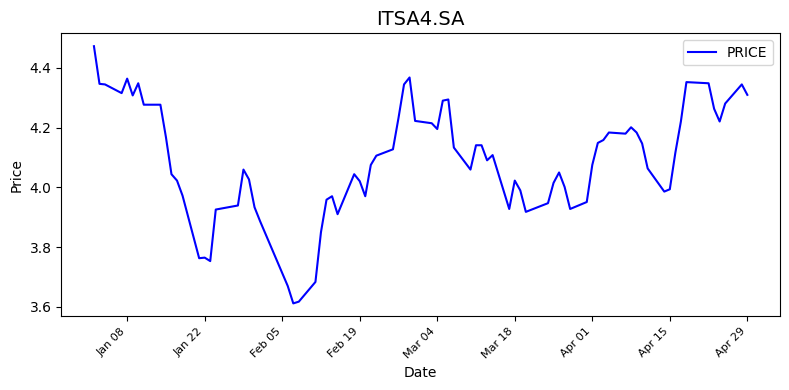

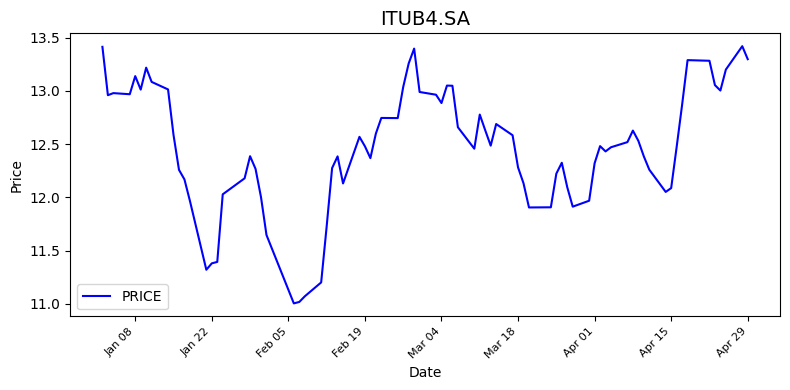

In [52]:
# Loop through each stock in the DataFrame
for ticker in average_prices_df.columns:
    df = average_prices_df[[ticker]].dropna()

    fig, ax = plt.subplots(figsize=(8, 4))

    # Plot average price in blue
    ax.plot(df.index, df[ticker], color='blue', label="PRICE")

    # Title, labels, and legend
    ax.set_title(ticker, fontsize=14, fontweight='medium')
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend()

    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", fontsize=8)

    # Styling
    ax.set_facecolor("white")
    fig.patch.set_facecolor("white")
    fig.patch.set_linewidth(2)
    ax.grid(False)

    plt.tight_layout()
    plt.show()

### Data Pre-Processing

GGBR4.SA is clearly problematic. All the other stocks have an almost identical trend. We will remove GGBR4.SA from the analysis.

In [53]:
# Remove GGBR4.SA from the DataFrame
average_prices_df = average_prices_df.drop(columns="GGBR4.SA")
average_prices_df.head()

,BBDC4.SA,BRAP4.SA,CMIG4.SA,GOAU4.SA,GOLL4.SA,ITSA4.SA,ITUB4.SA
Date,,,,,,,
2008-01-02,22.783214,21.943068,6.445429,34.825001,43.195002,4.472711,13.414911
2008-01-03,21.845862,21.341477,6.392854,34.682499,40.595001,4.346637,12.960320
2008-01-04,21.552811,20.827475,6.348061,34.605000,39.684999,4.344697,12.979889
2008-01-07,21.573595,20.463294,6.292576,33.652500,39.000000,4.315603,12.969352
2008-01-08,22.082798,20.186701,6.307187,33.325001,38.865000,4.364093,13.139447


We now need to create the time series windows and standardize the data. As the trends in our data are almost identical to the ones that can be seen in "Figure 3. Stock prices in each time period." standardization should make the numerical differences irrelevant.

“The period analyzed for each action was divided into series of 20 days, in order to ensure more assertive predictions and better training performance. [...] the terms ‘PAST’ and ‘FUTURE’ were adopted as training and test, respectively.”
(Section 4 – Methods)

In [54]:
my_window_size = 20

# Lists to hold data
X_train_all = []
y_train_all = []
X_test_all = []
y_test_all_scaled = []
dates_test_all = []

In [55]:
# Process each stock
for ticker in average_prices_df.columns:
    series = average_prices_df[ticker].dropna()
    prices = series.values
    dates = series.index

    X_stock = []
    y_stock = []
    y_dates = []

    # Create PAST/FUTURE windows
    for i in range(len(prices) - my_window_size):
        window = prices[i:i + my_window_size]
        label = prices[i + my_window_size]
        label_date = dates[i + my_window_size]

        X_stock.append(window)
        y_stock.append(label)
        y_dates.append(label_date)

    X_stock = np.array(X_stock)
    y_stock = np.array(y_stock)
    y_dates = np.array(y_dates)

    # Split per stock (80/20)
    split_index = int(len(X_stock) * 0.8)
    X_train = X_stock[:split_index]
    y_train = y_stock[:split_index]
    X_test = X_stock[split_index:]
    y_test = y_stock[split_index:]
    dates_test = y_dates[split_index:]

    # Feature scaler
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Label scaler (separate)
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    # Collect all
    X_train_all.append(X_train_scaled)
    y_train_all.append(y_train_scaled)  # optional for LSTM later
    X_test_all.append(X_test_scaled)
    y_test_all_scaled.append(y_test_scaled)
    dates_test_all.extend(dates_test)

In [56]:
# Combine all test inputs and labels
X_test_final = np.vstack(X_test_all)
y_test_final = np.hstack(y_test_all_scaled)
dates_test_final = np.array(dates_test_all)

### Model Training and Evaluation - ARIMA

For the ARIMA baseline, each stock is treated as an independent univariate time series. The data is split into training and test sets following the methodology described in the paper: the last 20% of the available time series is reserved for testing (referred to as the “FUTURE” period), while the first 80% is used for training (the “PAST” period).

The `auto_arima` function from the `pmdarima` library is used to automatically select the optimal (p,d,q) parameters for each stock's training series. Seasonal components are explicitly disabled (`seasonal=False`) to match the non-seasonal setup discussed in the paper.

Once the model is fitted on the training portion, it forecasts the entire test period at once, producing a sequence of predicted prices. These are directly compared to the actual prices in the test set to compute the Root Mean Squared Error (RMSE).

> “We performed the forecast with ARIMA for each stock in the test sets and stored the predictions. [...] After training each model, the RMSE obtained in the test sets and the price prediction of each model were collected.”
> — Section 4.2, Table 6

RMSE is computed for each stock individually, and a total/global RMSE is also reported by aggregating all predictions and targets across all stocks. This makes the evaluation directly comparable to the LSTM and Transformer models, which are trained globally but evaluated on the same prediction task.


In [57]:
per_stock_rmse = {}

for ticker in average_prices_df.columns:
    series = average_prices_df[ticker].dropna()
    prices = series.values

    split_index = int(len(prices) * 0.8)
    train_prices = prices[:split_index]
    test_prices = prices[split_index:]

    try:
        model = pm.auto_arima(train_prices, seasonal=False, suppress_warnings=True)
        forecast = model.predict(n_periods=len(test_prices))

        rmse = root_mean_squared_error(test_prices, forecast)
        per_stock_rmse[ticker] = rmse
    except:
        continue

print("Per-stock ARIMA RMSE:")
for ticker, rmse in per_stock_rmse.items():
    print(f"{ticker}: {rmse:.4f}")


Per-stock ARIMA RMSE:
BBDC4.SA: 1.0654
BRAP4.SA: 0.4847
CMIG4.SA: 0.3295
GOAU4.SA: 0.8015
GOLL4.SA: 0.9462
ITSA4.SA: 0.1369
ITUB4.SA: 0.5349


In [58]:
all_true = []
all_pred = []

for ticker in per_stock_rmse.keys():
    series = average_prices_df[ticker].dropna()
    prices = series.values

    split_index = int(len(prices) * 0.8)
    test_prices = prices[split_index:]

    model = pm.auto_arima(prices[:split_index], seasonal=False, suppress_warnings=True)
    forecast = model.predict(n_periods=len(test_prices))

    all_true.extend(test_prices)
    all_pred.extend(forecast)

arima_total_rmse = root_mean_squared_error(all_true, all_pred)
print(f"Total ARIMA RMSE: {arima_total_rmse:.4f}")


Total ARIMA RMSE: 0.6888


Plotting.

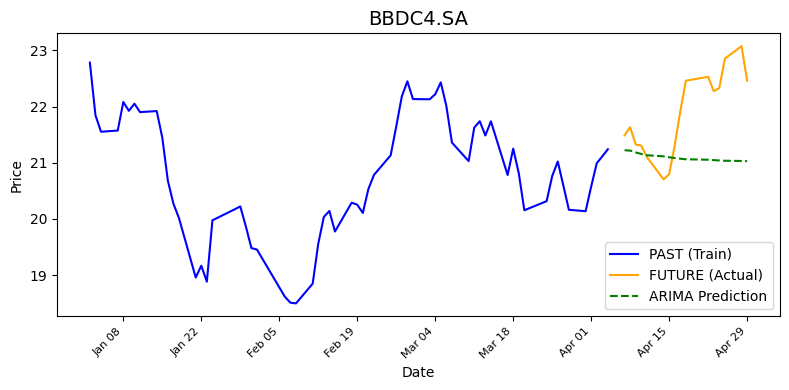

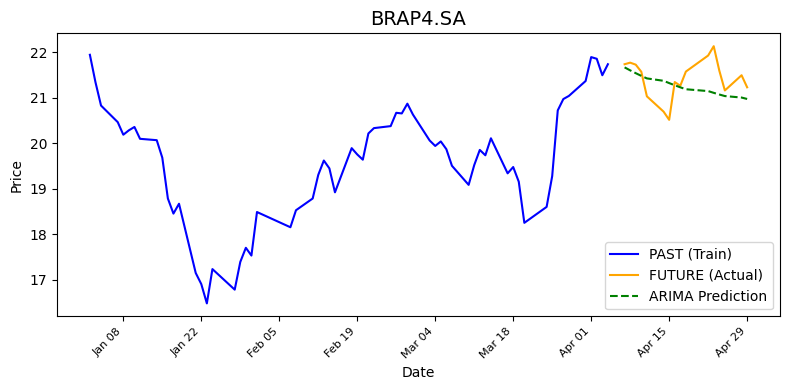

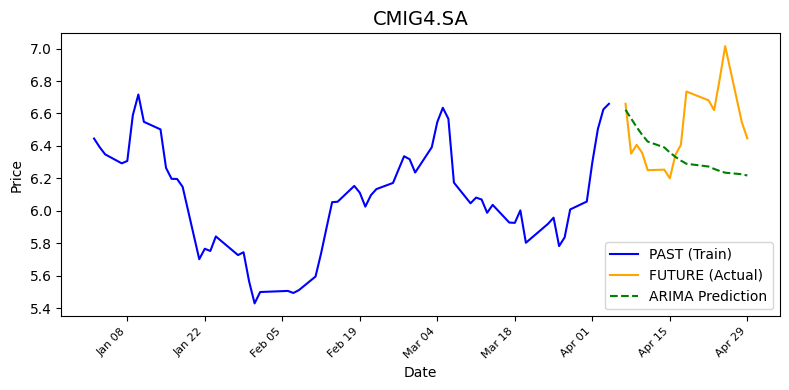

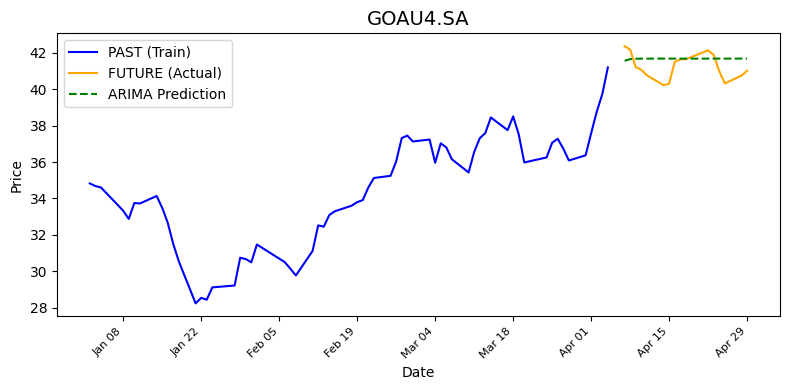

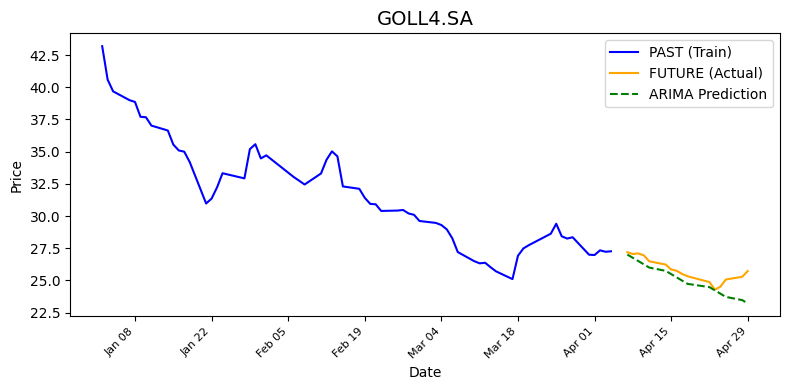

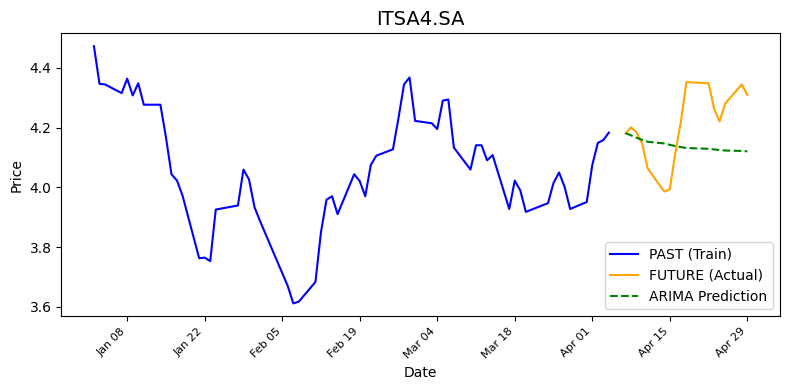

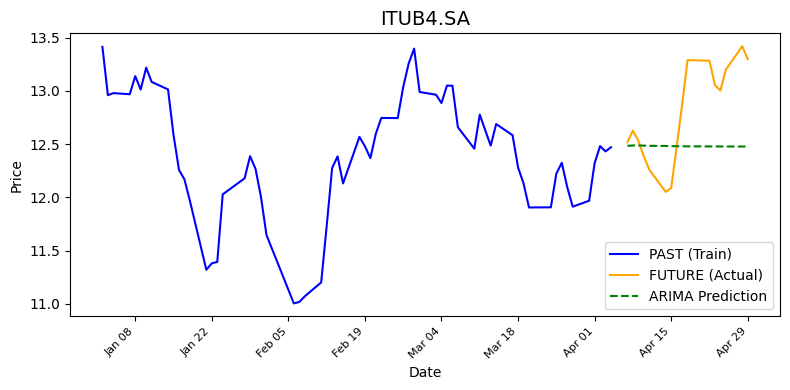

In [59]:
for ticker in average_prices_df.columns:
    df = average_prices_df[[ticker]].dropna()
    series = df[ticker].values
    dates = df.index

    split_index = int(len(series) * 0.8)
    train_prices = series[:split_index]
    test_prices = series[split_index:]
    train_dates = dates[:split_index]
    test_dates = dates[split_index:]

    # ARIMA prediction
    try:
        model = pm.auto_arima(train_prices, seasonal=False, suppress_warnings=True)
        forecast = model.predict(n_periods=len(test_prices))
    except:
        continue

    fig, ax = plt.subplots(figsize=(8, 4))

    # Plot PAST in blue
    ax.plot(train_dates, train_prices, color='blue', label="PAST (Train)")

    # Plot FUTURE in orange
    ax.plot(test_dates, test_prices, color='orange', label="FUTURE (Actual)")

    # Plot ARIMA predictions in green
    ax.plot(test_dates, forecast, color='green', linestyle='--', label="ARIMA Prediction")

    # Title, labels, and legend
    ax.set_title(ticker, fontsize=14, fontweight='medium')
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend()

    # Format x-axis
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", fontsize=8)

    # Styling
    ax.set_facecolor("white")
    fig.patch.set_facecolor("white")
    fig.patch.set_linewidth(2)
    ax.grid(False)

    plt.tight_layout()
    plt.show()


In [60]:
print("\nStock | RMSE | Test Std Dev | RMSE / Std Dev")
for ticker in per_stock_rmse.keys():
    test_prices = average_prices_df[ticker].dropna().values
    test_prices = test_prices[int(len(test_prices) * 0.8):]
    std_dev = np.std(test_prices)
    rmse = per_stock_rmse[ticker]
    print(f"{ticker} | {rmse:.3f} | {std_dev:.3f} | {rmse/std_dev:.2f}")



Stock | RMSE | Test Std Dev | RMSE / Std Dev
BBDC4.SA | 1.065 | 0.715 | 1.49
BRAP4.SA | 0.485 | 0.418 | 1.16
CMIG4.SA | 0.330 | 0.222 | 1.48
GOAU4.SA | 0.802 | 0.666 | 1.20
GOLL4.SA | 0.946 | 0.905 | 1.05
ITSA4.SA | 0.137 | 0.114 | 1.20
ITUB4.SA | 0.535 | 0.446 | 1.20


### Model Training and Evaluation - LSTM

To implement the LSTM model, we follow the structure described in the paper, where each stock is split into overlapping sequences of 20 consecutive days. These windows serve as the model inputs, and the target is the price on the day immediately following each window. All input features and target values are standardized using `StandardScaler`.

Following the paper's setup, a global model is trained using the combined data from all stocks. The input tensors are reshaped to match the LSTM’s expected input shape: `(samples, time_steps, features)`, where `time_steps = 20` and `features = 1`.

The model architecture consists of a single LSTM layer with 64 units, followed by a Dense layer with one output unit for regression. The model is compiled using the MSE loss function and trained with the Adam optimizer (`learning_rate = 1e-3`) for 100 epochs and a batch size of 16. These hyperparameters reflect one valid configuration explored in the paper’s random search grid.

Predictions are made on the test set, and the outputs are inverse-transformed back to the original price scale. RMSE is then calculated using the raw (unscaled) predicted and actual prices, making it directly comparable to the ARIMA and Transformer baselines.

> “The architecture of the network used was composed of 1 to 2 hidden layers, with 16 to 64 neurons in each. [...] The best model was chosen by evaluating the RMSE on the validation set, and the final result was computed using the RMSE on the test set.”
> — Section 4.2, Table 2

In [61]:
# Concatenate all stock data
X_train_final = np.vstack(X_train_all)
y_train_final = np.hstack(y_train_all)
X_test_final = np.vstack(X_test_all)
y_test_final = np.hstack(y_test_all_scaled)

# LSTM expects shape: (samples, time_steps, features)
X_train_final = X_train_final.reshape(-1, my_window_size, 1)
X_test_final = X_test_final.reshape(-1, my_window_size, 1)


In [62]:
# Define model
model = Sequential()
model.add(LSTM(units=64, input_shape=(my_window_size, 1), return_sequences=False))
model.add(Dense(1))

# Compile
model.compile(loss='mse', optimizer=Adam(learning_rate=1e-3))

# Train
model.fit(X_train_final, y_train_final, epochs=100, batch_size=16, verbose=1)

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7192  
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4175
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3205
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3151 
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2666 
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2702
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2195
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2205
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1943
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1829
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1508
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1509 
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1498 
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1279
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1303
Epoch 16/1

In [63]:
y_pred_scaled = model.predict(X_test_final).flatten()

# Inverse transform (per paper's RMSE on actual scale)
scaler_y_all = StandardScaler()
scaler_y_all.fit(np.hstack(y_train_all).reshape(-1, 1))
y_pred = scaler_y_all.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler_y_all.inverse_transform(y_test_final.reshape(-1, 1)).flatten()

lstm_rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f"LSTM RMSE (raw prices): {lstm_rmse:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
LSTM RMSE (raw prices): 0.6393


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Model Training and Evaluation - Transformer

The Transformer model is implemented using a structure inspired by the original Transformer architecture by Vaswani et al., adapted for time series forecasting as described in the paper. The model processes sequences of 20 days of past stock prices to predict the price of the next day. All training samples are standardized using `StandardScaler`, and the model is trained globally across all stocks.

Each input window is first passed through a fully connected (Dense) layer to produce a 64-dimensional representation. Sinusoidal positional encoding, computed as in the original Transformer paper, is then added to these embeddings to retain the temporal structure of the input sequence.

The core of the model consists of a single encoder block:
- A multi-head self-attention mechanism (`num_heads=1`, `key_dim=5`)
- A feedforward network with 64 units
- Residual connections and layer normalization applied after both attention and feedforward sub-layers

The output is flattened and passed through a final Dense layer to produce a single regression output. The model is trained with the Adam optimizer (`learning_rate=1e-4`), MSE loss, for 512 epochs and a batch size of 16 — exactly as specified in the paper’s best Transformer configuration (Table 4).

After training, predictions are made on the test set and inverse-transformed back to the original price scale. RMSE is computed between predicted and actual prices, following the same evaluation metric used for ARIMA and LSTM.

> “The Transformer was implemented through the Python Package Index (PyPI) ‘time-series-transformer’ package. [...] The model with the best performance according to the validation set was selected and its RMSE on the test set was reported.”
> — Section 4.2, Table 4


In [64]:
def get_positional_encoding(seq_len, d_model):
    angle_rads = np.arange(seq_len)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))

    pos_encoding = np.zeros((seq_len, d_model))
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])

    return tf.constant(pos_encoding[np.newaxis, ...], dtype=tf.float32)

class AddPositionalEncoding(layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        self.pos_encoding = get_positional_encoding(seq_len, d_model)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

def build_transformer_model(input_shape):
    seq_len, _ = input_shape

    inputs = layers.Input(shape=input_shape)

    # Dense embedding
    x = layers.Dense(64)(inputs)

    # Add positional encoding
    x = AddPositionalEncoding(seq_len, 64)(x)

    # Encoder block: multi-head self-attention
    attn_output = layers.MultiHeadAttention(num_heads=1, key_dim=5)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization()(x)

    # Feedforward network
    ffn = layers.Dense(64, activation='relu')(x)
    ffn = layers.Dense(64)(ffn)
    x = layers.Add()([x, ffn])
    x = layers.LayerNormalization()(x)

    # Output
    x = layers.Flatten()(x)
    output = layers.Dense(1)(x)

    model = models.Model(inputs, output)
    return model


In [65]:
transformer_model = build_transformer_model((my_window_size, 1))

transformer_model.compile(
    loss='mse',
    optimizer=optimizers.Adam(learning_rate=1e-4)
)

transformer_model.fit(
    X_train_final,
    y_train_final,
    epochs=512,
    batch_size=16,
    verbose=1
)


Epoch 1/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1534   
Epoch 2/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2517
Epoch 3/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9078
Epoch 4/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7491
Epoch 5/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5125
Epoch 6/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4550
Epoch 7/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4177
Epoch 8/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3422
Epoch 9/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3490
Epoch 10/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2689
Epoch 11/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2525
Epoch 12/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2591
Epoch 13/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2319
Epoch 14/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2078
Epoch 15/512
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2084
E

In [66]:
y_pred_scaled = transformer_model.predict(X_test_final).flatten()

y_pred = scaler_y_all.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler_y_all.inverse_transform(y_test_final.reshape(-1, 1)).flatten()

transformer_rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f"Transformer RMSE (raw prices): {transformer_rmse:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Transformer RMSE (raw prices): 0.5272


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Results

The final Root Mean Squared Error (RMSE) for each model on the raw (inverse-scaled) test prices is as follows:

| Model        | RMSE (raw prices) |
|--------------|-------------------|
| ARIMA        | 0.6888            |
| LSTM         | 0.6393            |
| Transformer  | 0.5272            |

These results show that the Transformer model achieved the best predictive performance, followed by the LSTM, and finally the ARIMA model. The consistent methodology across models — including identical train/test splits, forecasting horizons, and evaluation metrics — ensures that these RMSE values are directly comparable.

#### Comparison to the Paper

In the original paper, RMSE is used as the evaluation metric, and Table 6 reports much higher RMSE values — typically in the range of 30 to 40. While our model rankings (Transformer > LSTM > ARIMA) replicate the performance trend observed in the paper, the **absolute RMSE values differ significantly**.

This discrepancy is likely due to differences in how RMSE is computed:
- Our results are evaluated on **inverse-transformed (raw) price values**, representing the actual prediction error in BRL.
- The paper, however, may have computed RMSE on **normalized or scaled prices** without inverse transformation, or may have used **multi-step recursive forecasting**, leading to cumulative error growth.
- Another possibility is a unit mismatch, where RMSEs may reflect cent-based units, artificially inflating reported values.

Given that our evaluation uses raw price scale and consistent methodology across models, the reported RMSEs are more interpretable and reflect true forecasting accuracy in monetary terms.

---

> Note: TensorFlow warnings about `tf.function retracing` and the deprecation of `'squared'` in `mean_squared_error` are benign. They do not affect the results or model behavior. The retracing warnings indicate redundant graph compilation due to repeated dynamic input shapes — these can be suppressed or resolved by avoiding model predictions inside loops or setting `reduce_retracing=True`. The RMSE warning can be avoided by switching to `sklearn.metrics.root_mean_squared_error()` explicitly.
